In [1]:
# change to parent directory to import module
%cd ..

/home/achilleas/projects/osbuild/metrics


In [2]:
# imports, function definitions, and global settings
import json
import pandas
import report

import numpy as np
import matplotlib.pyplot as plt
import ibmetrics as ib

from datetime import datetime, timedelta

from IPython.display import display, Markdown


def mdprint(msg):
    display(Markdown(msg))


plt.style.use('tableau-colorblind10')

In [3]:
# read data
builds = report.read_file("./data/dump-2022-10-17.log")
users = pandas.read_json("./data/userinfo.json", dtype=False)
with open("./data/userfilter.txt", encoding="utf-8") as filterfile:
    user_filter = filterfile.read().split("\n")

mdprint(f"Read {len(builds)} records")

Using cached pickle file at /home/achilleas/.cache/osbuild-metrics/dump-2022-10-17.pkl


Read 6338 records

In [4]:
# filtering: remove builds before GA
ga_date = datetime(2022, 5, 4)
ga_idxs = builds["created_at"] >= ga_date
builds = builds.loc[ga_idxs]
mdprint(f"Using {len(builds)} records (since GA)")

# filtering: remove internal users
builds = ib.data.filter_users(builds, users, user_filter)
mdprint(f"Using {len(builds)} records (after filtering)")

Using 4504 records (since GA)

Using 1875 records (after filtering)

In [5]:
summary = ib.metrics.make_summary(builds)
mdprint(ib.metrics.summarise(summary))

Summary
=======

Period: 2022-05-04 14:11:47.137615 - 2022-10-16 17:42:19.002261

- Total builds: 1875
- Number of users: 713
- Builds with packages: 1081
- Builds with filesystem customizations: 664
- Builds with custom repos: 22

Text(0.5, 1.0, 'Footprints')

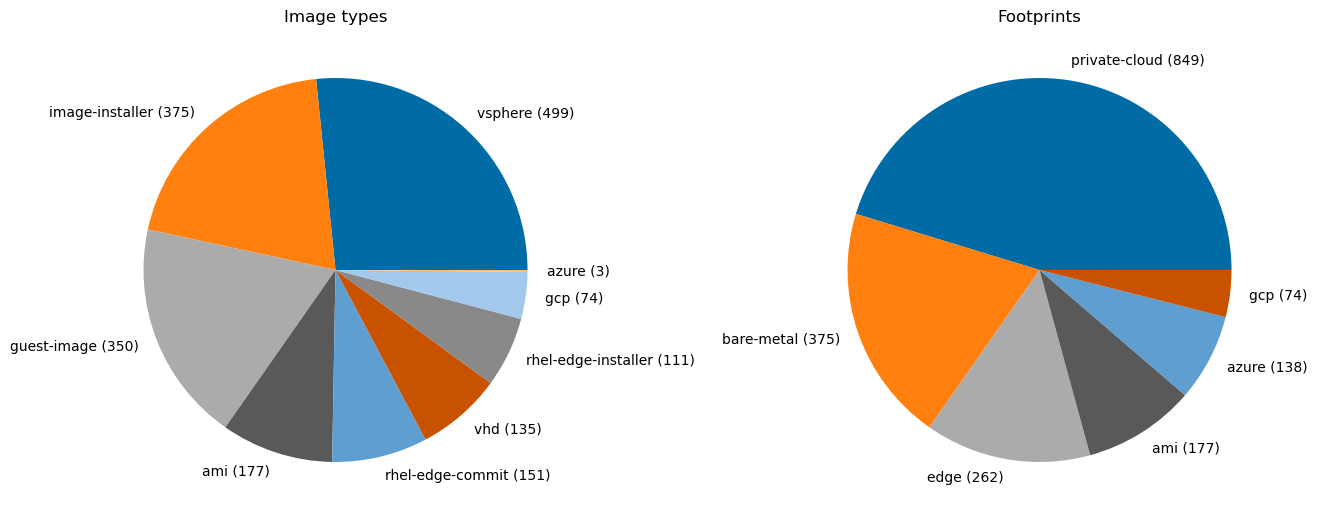

In [6]:
fig = plt.figure()
ax1 = fig.add_axes([0, 0, 1, 1])
ib.plot.imagetype_builds(builds, ax1)
ax1.set_title("Image types")

ax2 = fig.add_axes([1.1, 0, 1, 1])
ib.plot.footprint_builds(builds, ax2)
ax2.set_title("Footprints")

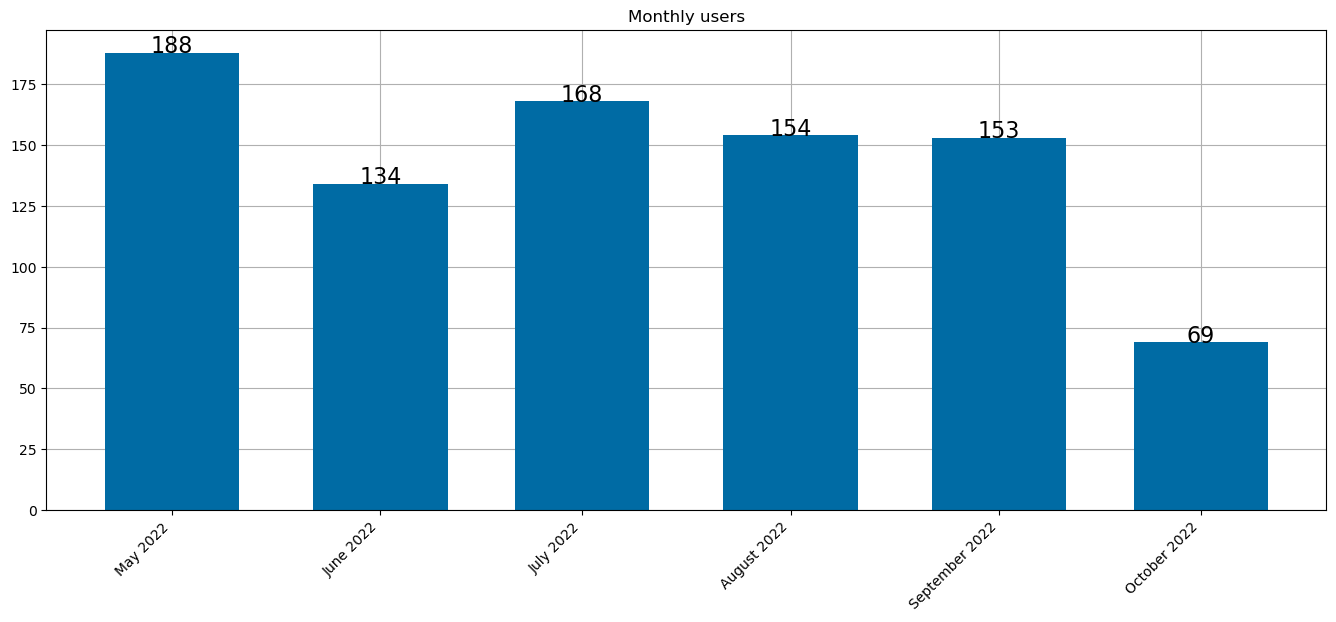

In [7]:
fig = plt.figure()
users_ax = fig.add_axes([0, 3, 2, 1])
ib.plot.monthly_users(builds, users_ax)

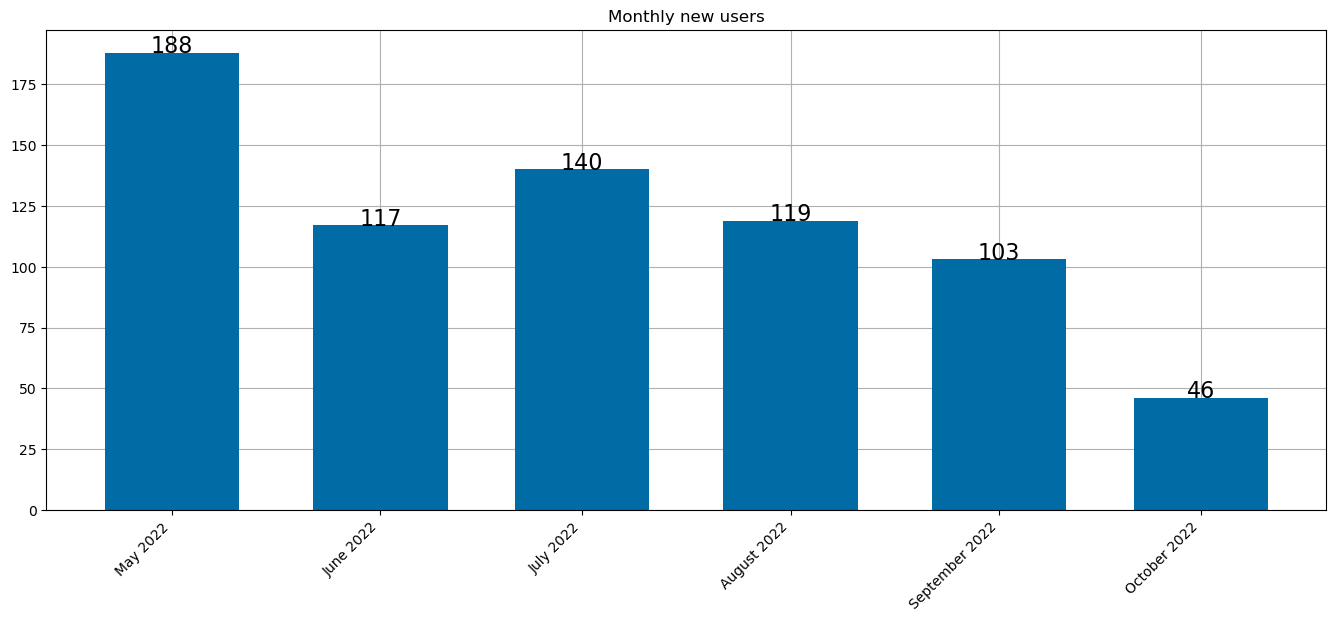

In [8]:
fig = plt.figure()
new_users_ax = fig.add_axes([0, 1.5, 2, 1])
ib.plot.monthly_new_users(builds, new_users_ax)

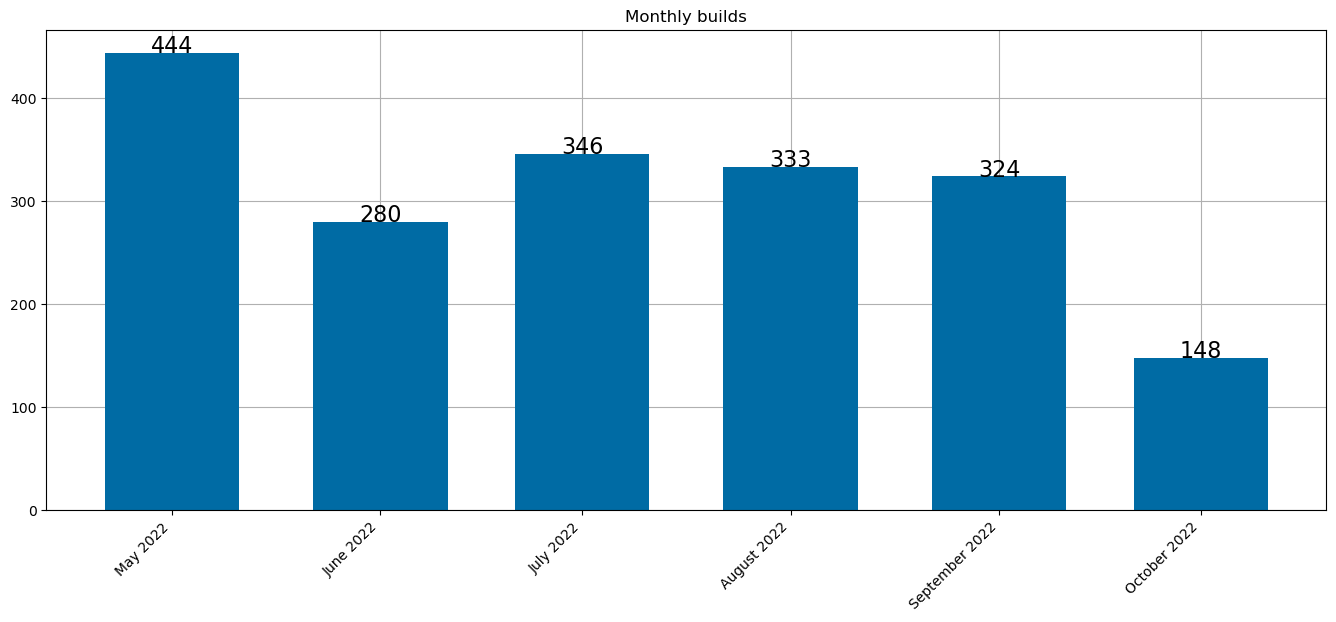

In [9]:
fig = plt.figure()
builds_ax = fig.add_axes([0, 0, 2, 1])
ib.plot.monthly_builds(builds, builds_ax)

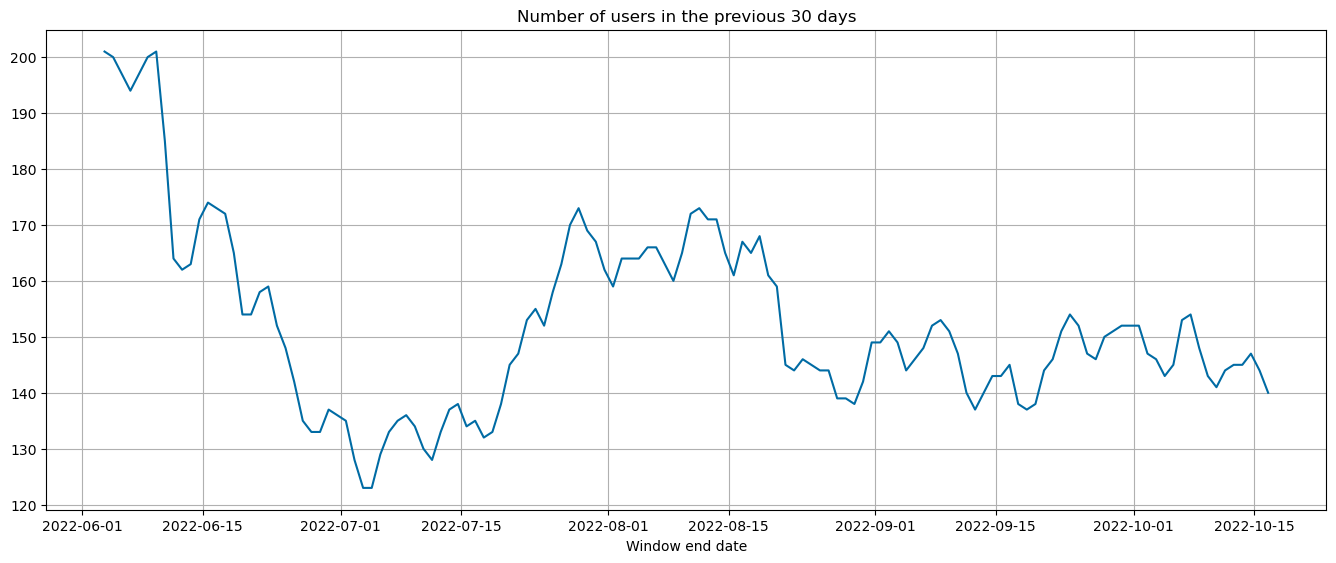

In [10]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 2, 1])
ib.plot.users_sliding_window(builds, ax)

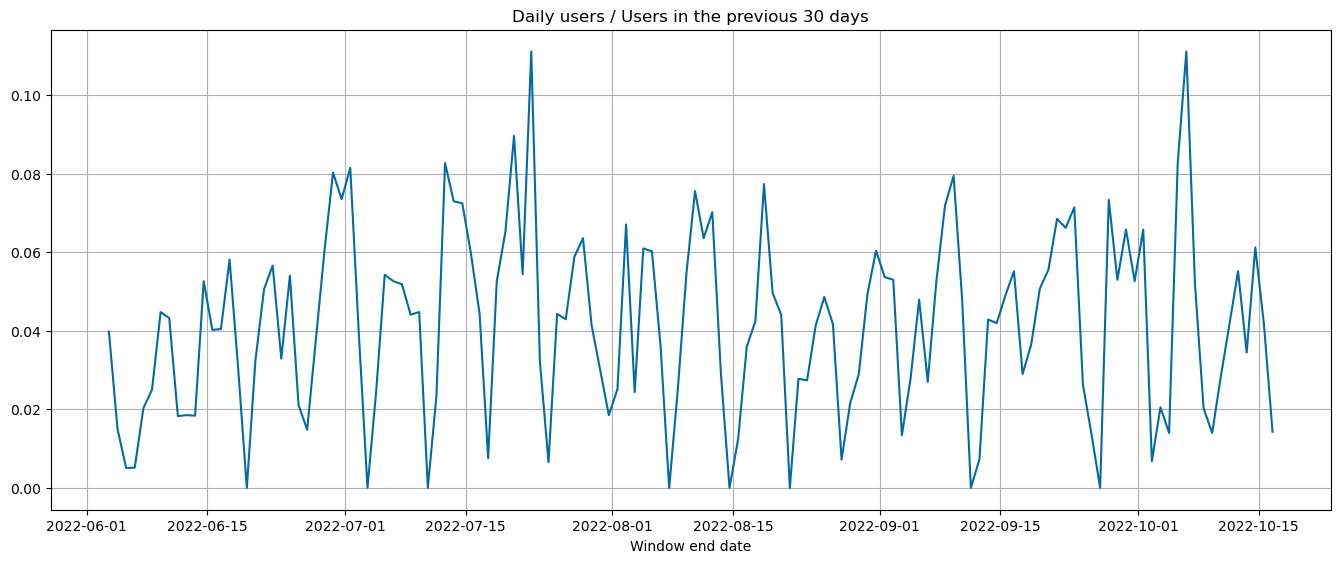

In [11]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 2, 1])
ib.plot.dau_over_mau(builds, ax)

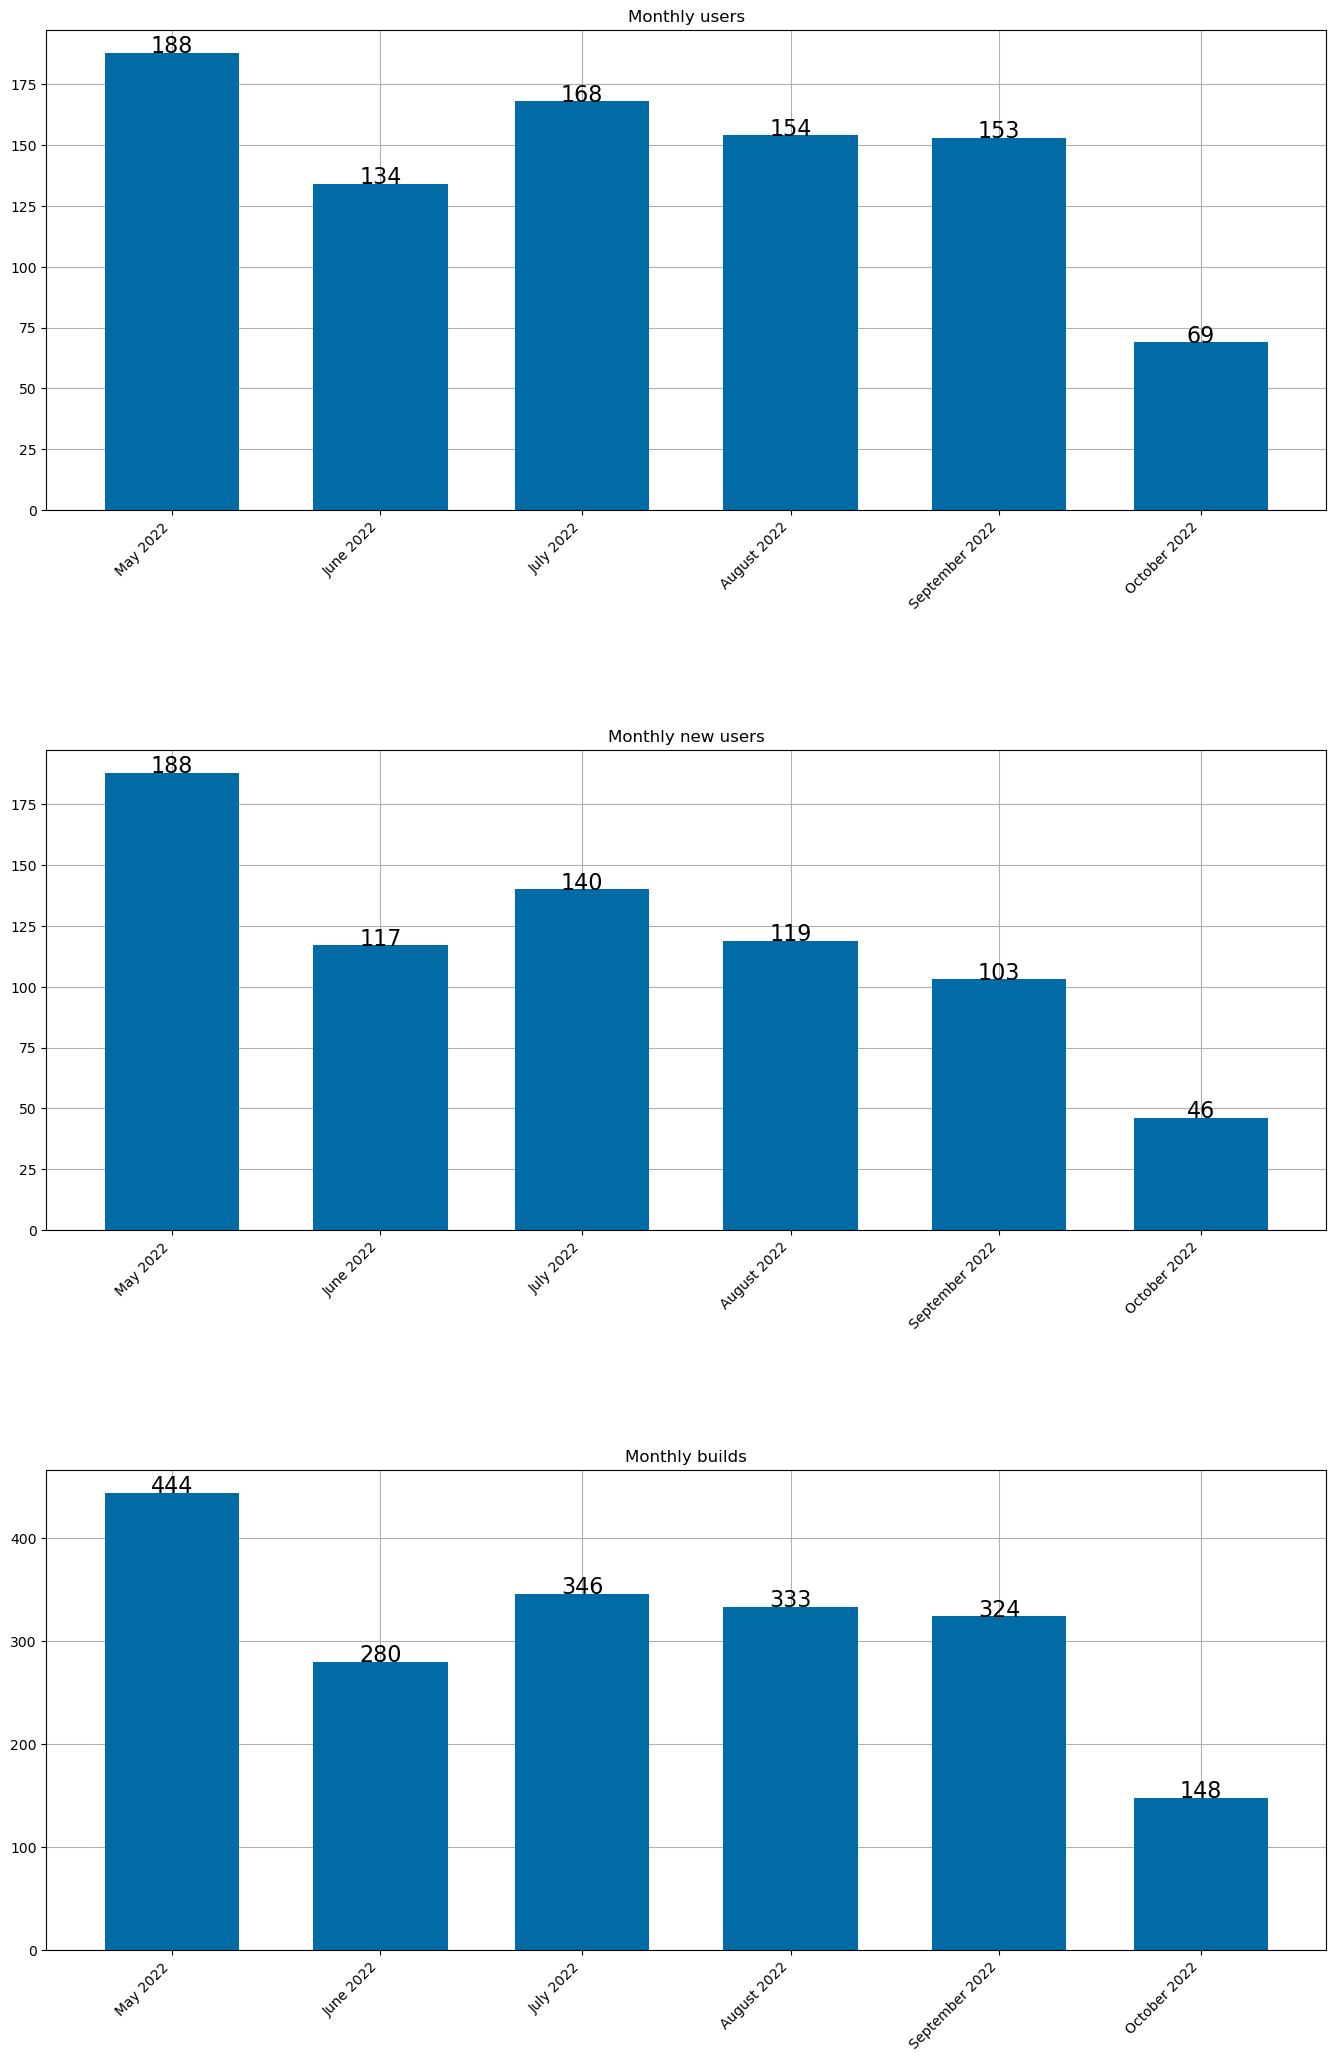

In [12]:
# draw bar graphs again on one figure for convenience
fig = plt.figure()
users_ax = fig.add_axes([0, 3, 2, 1])
ib.plot.monthly_users(builds, users_ax)

new_users_ax = fig.add_axes([0, 1.5, 2, 1])
ib.plot.monthly_new_users(builds, new_users_ax)

builds_ax = fig.add_axes([0, 0, 2, 1])
ib.plot.monthly_builds(builds, builds_ax)